In [1]:
from sage.all import *
import math
import secrets
import hashlib
import numpy as np
import pickle

# Algoritmos de apoyo: Parte 1

- Generación de semilla "aleatoria"
- Expansión de semilla a matriz/vector en grupo 
- Expansión de semilla privada
- Árbol de semillas

In [2]:
def generate_seed(bit_size):
    byte_size = bit_size // 8
    return secrets.token_bytes(byte_size)

def expand_seed_to_matrix(seed, n, k, p):
    shake = hashlib.shake_128(seed)
    total_elements = (n - k) * k  # Número total de elementos en la matriz aleatoria
    random_bytes = shake.digest(total_elements)  # Generar los bytes necesarios

    # Convertir los bytes en una matriz de enteros en el rango [0, 255]
    random_values = np.frombuffer(random_bytes, dtype=np.uint8).reshape(n - k, k)%p

    # Crear la matriz identidad de tamaño k x k
    identity_matrix = np.eye((n-k), dtype=np.uint8)

    # Concatenar la matriz aleatoria con la matriz identidad
    final_matrix = np.hstack((identity_matrix, random_values))

    return final_matrix

def expand_seed_to_Group(seed: bytes, group:str, p: int = 7, n: int = 7, t=7, w=4, E: list = [1, 2, 4], Fz: list = [0, 1, 2]):
    # Expandir la semilla con SHAKE128 para generar n bytes adicionales
    shake = hashlib.shake_128()
    shake.update(seed)
    
    # Generar suficientes bytes (uno por elemento del vector)
    expanded_bytes = shake.digest(n)  # Genera 'n' bytes
    
    # Convertir bytes a enteros y mapear a un grupo
    # Grupo Fp (grupo finito con p elementos)
    if group == "Fp":
        vector_fp = vector(GF(p), [b % p for b in expanded_bytes])
        return vector_fp
    # Grupo Fp* (multiplicativo, de 1 a p-1)
    elif group == "Fp*":
        expanded_bytes = shake.digest(t)
        vector_fpm = vector([(b % (p-1)) + 1 for b in expanded_bytes]) 
        return vector_fpm
    # Grupo B (vectores binarios de longitud t y peso w)
    elif group == "B":
        if w > t:
            raise ValueError("El peso w no puede ser mayor que la longitud t")
        
        expanded_bytes = shake.digest(2 * t)  # Más bytes para asegurar distribución uniforme
        indices = sorted(set(b % t for b in expanded_bytes))[:w]  # Seleccionar `w` índices únicos
        
        #Crear el vector binario con 'w' 1s en posiciones aleatorias
        vector_B = [1 if i in indices else 0 for i in range(t)]
        return vector_B 
    elif group == "Fz": 
        vector_E = vector([Fz[b % len(Fz)] for b in expanded_bytes])
        return vector_E
    else: 
        vector_E = vector([E[b % len(E)] for b in expanded_bytes])
        return vector_E

def expand_private_seed(seed_sk, params):
    l, n, k, p = params
    shake = hashlib.shake_128(seed_sk)
    derived_bytes = shake.digest(2*l)
    seed_e, seed_pk = derived_bytes[:l], derived_bytes[l//2:]
    H = expand_seed_to_matrix(seed_pk, n, k, p)
    eta = expand_seed_to_Group(seed_e, 'Fz')
    return eta, H

def seed_tree_leaves(m_seed, salt, params):
    l, t = params
    lambda_bytes = l // 8  # Convertir bits a bytes
    salt_bytes = salt  # Salt de 2λ bytes ya en formato bytes

    # 1. Crear la raíz del árbol
    root = m_seed + salt_bytes  # Raíz = Mseed || Salt
    
    # Lista para almacenar todos los nodos generados en orden
    nodes = {0: root}

    # 2. Construcción del árbol binario
    index = 1  # Para numerar los nodos
    while len(nodes) < t+1:  # Hasta tener suficientes nodos para al menos t hojas
        parent_index = (index - 1) // 2  # Índice del padre en el árbol
        parent_seed = nodes[parent_index]  # Semilla del padre

        # Generar 3λ bits (384 bits si λ=128) como salida del CSPRNG (SHAKE128)
        shake = hashlib.shake_128(parent_seed + salt_bytes)
        pseudo_random_bits = shake.digest(3 * lambda_bytes)  # 3λ bytes

        # Concatenar el índice del nodo (como bytes)
        node_seed = pseudo_random_bits + index.to_bytes(4, 'big')  # 4 bytes para el índice
        nodes[index] = node_seed
        index += 1

    # 3. Extraer las primeras t hojas del árbol
    #leaf_start = len(nodes) // 2  # Primer índice de una hoja
    #leaves = [nodes[i] for i in range(leaf_start, leaf_start + t)]
    seed_tree = [nodes[i] for i in range(1, t+1)]

    return seed_tree

# Algoritmos de apoyo: Parte 2
- MerkleRoot
- MerkleProofs
- RecomputeMerkleRoot

In [56]:
def sha256(data):
    return hashlib.sha256(data).digest()

#Prioridad hacia derecha, árboles balanceados a la izquierda
def setupTree(t):
    off = [0]*int(math.ceil(math.log2(t))+1)
    num = []
    levels = math.ceil(math.log2(t))+1
    for i in range(levels):
        num.append(2**i)
    num[-1] = 2*(t%2**(i-1))
    res_nodes = t - 2*(t%2**(i-1))

    #off[-2] = res_nodes
    off[-1] = 2**(i-1) - res_nodes
    off[-2] = res_nodes
    return off, num

def leafIndices(off,t):
    idx = []
    nodes_i = 2**(math.ceil(math.log2(t))-1)-1
    nodes_last = 2**(math.ceil(math.log2(t))-1) - ((t%2**(math.floor(math.log2(t)))))
    nodes_count = 0
    off_lvl = 0
    for i in range(t):
        if nodes_count == nodes_last:
            off_lvl = off[-1]
        idx.append(nodes_i + off_lvl)
        nodes_i += 1
        nodes_count += 1
    return idx

def updateCtr(ctr, lvl, num):
    lvl_nodes = num[lvl+1]
    ctr += 2
    if lvl_nodes == ctr:
        lvl -= 1
        ctr = 0
    return ctr, lvl

def merkleRoot(cmt0):
    t = len(cmt0)
    off, num = setupTree(t)
    idx = leafIndices(off, t)

    T = [None]*(2*t-1)
    for i in range(0, t):
        T[idx[i]] = cmt0[i]
    
    lvl = math.ceil(math.log2(t)) - 1
    ctr = 0
    for i in range(2*t-2, 0, -2):
        p = math.floor((i-1)/2) + off[lvl]
        #print(f'lvl:{lvl}\tp:{p}\ti:{i}\tT[i-1]:{T[i-1]}\tnT[i]:{T[i]}')
        T[p] = bytes.fromhex(hashlib.sha3_256(T[i-1] + T[i]).hexdigest())
        ctr, lvl = updateCtr(ctr, lvl, num)
    return T[0], T

def merkleProofs(T, cmt0, b):
    t = len(cmt0)
    off, num = setupTree(t)
    idx = leafIndices(off, t)

    T_ = [0]*(2*t-1)
    for i in range(0, t):
        if b[i] == 0:
            T_[idx[i]] = 1

    lvl = math.ceil(math.log2(t))-1
    ctr = 0
    merkle_proofs = []
    for i in range(2*t-2, 0, -2):
        p = math.floor((i-1)/2) + off[lvl]
        #print(f'p:{p}\ti:{i}')
        T_[p] = T_[i-1] or T_[i]

        #right child computed, left child not so add it to proof
        if T_[i] == 1 and T_[i-1] == 0:
            merkle_proofs.append(T[i-1])
        
        #left child computed, right child not so add it to proof
        if T_[i] == 0 and T_[i-1] == 1:
            merkle_proofs.append(T[i]) #CAMBIO
        ctr, lvl = updateCtr(ctr, lvl, num)
        #print(f"num:{num}\tlvl{lvl}\tT':{T_}")
    
    return merkle_proofs

def recomputeMerkleRoot(cmt0, merkle_proofs, b):
    t = len(cmt0)
    off, num = setupTree(t)
    idx = leafIndices(off, t)

    T_ = [0]*(2*t-1)
    T = [0]*(2*t-1)
    for i in range(0, t):
        if b[i] == 0:
            T_[idx[i]] = 1
            T[idx[i]] = cmt0[i]

    lvl = math.ceil(math.log2(t))-1
    ctr = 0
    l = 0
    h = ['T[i-1]', 'T[i]']
    for i in range(2*t-2, 0, -2):
        if T_[i] == 0 and T_[i-1] == 0:
            ctr, lvl = updateCtr(ctr, lvl, num)
            continue
    
        #take first node from tree if valid, else from proof
        if T_[i] == 1:
            h[1] = T[i]
        else:
            h[1] = merkle_proofs[l]
            l += 1
        
        #take second node from tree if valid, else from proof
        if T_[i-1] == 1:
            h[0] = T[i-1]
        else:
            h[0] = merkle_proofs[l]
            l += 1
        
        p = math.floor((i-1)/2) + off[lvl]
        #print(f'p:{p}\ti:{i}')
        T[p] = bytes.fromhex(hashlib.sha3_256(h[0]+h[1]).hexdigest())
        T_[p] = 1
        #print(f"T':{T_}") #CAMBIO
        ctr, lvl = updateCtr(ctr, lvl, num)
    #CAMBIO
    #print("T:")
    #for j in range(len(T)):
    #    print(f'{j}:{T[j] if type(T[j]) == int else T[j].hex()}')
    d_0 = T[0]
    return d_0

In [71]:
def keyGen(l, n, k, p=7, g=4):
    seed_sk = generate_seed(l)
    shake = hashlib.shake_128(seed_sk)
    derived_bytes = shake.digest(2*l)
    seed_e, seed_pk = derived_bytes[:l], derived_bytes[l//2:]
    H = expand_seed_to_matrix(seed_pk, n, k, p)
    eta = expand_seed_to_Group(seed_e, 'Fz')
    e = vector([g**eta_i for eta_i in eta])
    s = np.matmul(e,H.transpose())%p
    sk = seed_sk
    pk = seed_pk, s
    return sk, pk

sk, pk = keyGen(128, 7, 4)
print(f'sk=>\nseed_sk: {sk.hex()}\npk=>\nseed_pk: {pk[0].hex()}\ns: {pk[1]}')

sk=>
seed_sk: 4c773a8eeb386b5351a88c59c243b286
pk=>
seed_pk: 8bb385eb1795c566ecc709cc124d9e935fb4b1048a5c153647550292cbea133b95d8f6ed3b7d8cb47e0f0b28a04fdb58f8e36775206967b0c0ae1645d6ba4c00ad9f242fdfd1e9e89079133913094f31bffcb6e3943d69bba95739fe53deabdc3915c5fba4832e41ac3015a31d475234defa246c36f14478acb7c69f0a09496e31310fe84a7c3cfe7cdc0cfa9cdd3b112d87e3fe91cd59dce2408f7711b14077e4c826ee067df192fb60b2440eb0b3b6f586f624eaab319b8b94796159eb82e3
s: [1 6 1]


In [69]:
def sign(sk, msg, params):
    l, g, t, n, k, p, Fz = params

    eta, H = expand_private_seed(sk, [l, n, k, p])

    MSeed = generate_seed(l)
    Salt = generate_seed(2*l)
    seeds = seed_tree_leaves(MSeed, Salt, [l, t])
    seedue = []
    eta_list = []
    u_list = []
    sigmas = []
    s_s = []
    e_s = []
    cmt0, cmt1 = [], []
    for i in range(0, t):
        shake = hashlib.shake_128(seeds[i])
        derived_bytes = shake.digest(2*l)
        seed_u, seed_e = derived_bytes[:l], derived_bytes[l//2:]
        seedue.append(seed_u.hex() + "|" + seed_e.hex())
        eta_ = expand_seed_to_Group(seed_e, 'Fz')
        eta_list.append(eta_)
        #sigma_i = vector(eta - eta_)%3
        sigma_i = eta - eta_
        sigma_i = vector([Fz[b % len(Fz)] for b in sigma_i])
        sigmas.append(sigma_i)
        v = vector([g**sigma_v for sigma_v in sigma_i])%7
        u_ = expand_seed_to_Group(seed_u, 'Fp')
        u_list.append(u_)
        u = np.multiply(v,u_)%7
        s_ = np.matmul(u, H.transpose())%p
        s_s.append(vector(s_))
        cmt0_i = bytes([int(x) for x in s_]) + bytes([int(x) for x in sigma_i]) + Salt + i.to_bytes(4, 'big')
        cmt0.append(bytes.fromhex(hashlib.sha3_256(cmt0_i).hexdigest()))
        cmt1_i = seeds[i] + Salt + i.to_bytes(4, 'big')
        cmt1.append(hashlib.sha3_256(cmt1_i).hexdigest())
    d0, T = merkleRoot(cmt0)
    d1 = bytes.fromhex(hashlib.sha3_256(bytes.fromhex(''.join(cmt1))).hexdigest())
    d01 = d0 + d1

    #Extracción del primer vector desafío, en ZKP hecho por el verificador, acá simulado autónomamente
    dm = bytes.fromhex(hashlib.sha3_256(bytes.fromhex(msg.encode('utf-8').hex())).hexdigest())
    dbeta = bytes.fromhex(hashlib.sha3_256(dm + d01 + Salt).hexdigest())
    beta = expand_seed_to_Group(dbeta, 'Fp*')

    #Cálculo del primer round de respuestas 
    y = []
    for i in range(0, t):
        e_ = vector([g**eta_i for eta_i in eta_list[i]])%p
        e_s.append(e_)
        y.append((u_list[i] + beta[i]*e_%7)%7)
    
    #Extracción del segundo vector desafío
    y_hex = ["".join(bytes([int(x) for x in y_i]).hex()) for y_i in y]
    db = bytes.fromhex(hashlib.sha3_256(bytes.fromhex("".join(y_hex))).hexdigest()) #+ dbeta).hexdigest())
    b = expand_seed_to_Group(db, 'B')

    #Cálculo del segundo round de respuestas
    merkle_proofs = merkleProofs(T, cmt0, b)
    #seed_path = seed_tree_paths(MSeed, b)

    rsp0, rsp1 = [], []
    for i in range(0, t):
        if b[i] == 0:
            rsp0.append((y[i], sigmas[i]))
            rsp1.append(cmt1[i])
    
    signature = MSeed, Salt, d01, db, merkle_proofs, rsp0, rsp1 #, d1, cmt0, b, d0, sigmas, y, beta #, seed_path

    print(f'0. e = {vector([g**eta_i for eta_i in eta])%7}\n                    {H[0]}\n   E = [1,2,4], H = {H[1]}, s = {np.matmul(vector([g**eta_i for eta_i in eta])%7, H.transpose())%7}\n                    {H[2]}')
    print(f'1. MSeed = {MSeed.hex()}\n   Salt = {Salt.hex()}')
    print(f'2. SeedTree = {[seed.hex() for seed in seeds]}')
    print(f"3. Seedu' + Seede' = {seedue}\n   eta = {eta_list}\n   sigma = {sigmas}\n   s = {s_s}\n   cmt0 = {[cmt0_i.hex() for cmt0_i in cmt0]}\n   cmt1 = {cmt1}")
    print(f'4. d0, T = {d0.hex()}, {[x.hex() for x in T]}')
    print(f'5. d1 = {d1.hex()}\n   d01 = {d01.hex()}\n   dm = {dm.hex()}\n   dbeta = {dbeta.hex()}\n   beta = {beta}')
    print(f"6. e'= {e_s}\n   y = {y}")
    print(f'7. h = {y_hex}\n   db = {db.hex()}\n   b = {vector(b)}')
    print(f'8. Pendiente (por ahora)')
    print(f'9. merkleProofs = {[proof.hex() for proof in merkle_proofs]}')
    print(f'10. rsp0 = {rsp0}\n    rsp1 = {rsp1}')
    print(f'11. Signature = {Salt.hex()} | {d01.hex()} | {db.hex()} | {[proof.hex() for proof in merkle_proofs]} | {rsp0} | {rsp1}')
    
    signature = pickle.dumps(signature)  # Serializa la tupla a bytes
    return signature.hex()

signature = sign(sk, 'Hola Mundo!', [128, 4, 7, 7, 4, 7, [0,1,2]])  
print(signature)  

0. e = (4, 4, 2, 1, 1, 4, 4)
                    [1 0 0 0 5 4 4]
   E = [1,2,4], H = [0 1 0 0 4 3 5], s = [6 5 6]
                    [0 0 1 4 3 4 4]
1. MSeed = f3c6f58526721f9b4e701426a82cf954
   Salt = d65ba2effa49ded1a93872f2f1978e2f7121cbc3b1b590334958f18883e5e3bc
2. SeedTree = ['fe52f10af97debdfbe732d9541ebf4e40f60ece7d3f8e146ab2b6dfdce0ee5aad2004e019342959b76ee6515da42123600000001', 'fe52f10af97debdfbe732d9541ebf4e40f60ece7d3f8e146ab2b6dfdce0ee5aad2004e019342959b76ee6515da42123600000002', '3d7f6609e64a21bc6e8402331094f420381f344cfe1fdab56a84f217b642ace5e239194fa705585ae5a2a2b697bac61800000003', '3d7f6609e64a21bc6e8402331094f420381f344cfe1fdab56a84f217b642ace5e239194fa705585ae5a2a2b697bac61800000004', '03dbfc91465d03f6a6ad77f9c4c1487a51b760314d446ba9ff6d248c230ae5bc3e434fc838d9eeffa4b67cf87da3700f00000005', '03dbfc91465d03f6a6ad77f9c4c1487a51b760314d446ba9ff6d248c230ae5bc3e434fc838d9eeffa4b67cf87da3700f00000006', '4582e60b322d77162f3a53b9734b085798ce60b008e1193e533165ca77bdd3bac50

In [70]:
def verify(pk, msg, signature, params):
    l, g, t, n, k, p, Fz = params
    seed_pk, s = pk    
    signature = pickle.loads(bytes.fromhex(signature))

    MSeed, Salt, d01, db, merkle_proofs, rsp0, rsp1 = signature #, d1o, cmto, bo, d0o, sigmaso, yo, betao  = signature#, d1, cmt0_o, b, d0 = signature #, seed_path

    H = expand_seed_to_matrix(seed_pk, n, k, p)
    
    #Se recalculan los desafíos
    dm = bytes.fromhex(hashlib.sha3_256(bytes.fromhex(msg.encode('utf-8').hex())).hexdigest())
    dbeta = bytes.fromhex(hashlib.sha3_256(dm + d01 + Salt).hexdigest())
    beta = expand_seed_to_Group(dbeta, 'Fp*')
    b = expand_seed_to_Group(db, 'B')
    #print(f"merkleProofs = {[proof.hex() for proof in merkle_proofs]}\nb={b}\nbeta={beta}")

    #seeds = rebuildSeedTreeLeaves(seed_path, b, Salt)
    seeds = seed_tree_leaves(MSeed, Salt, [l, t])

    j = 0
    cmt0 = []
    cmt1 = []
    y = []
    s_s = []
    for i in range(0, t):
        if b[i] == 1:
            cmt0.append(bytes(0))
            cmt1_i = seeds[i] + Salt + i.to_bytes(4, 'big')
            cmt1.append(hashlib.sha3_256(cmt1_i).hexdigest())
            shake = hashlib.shake_128(seeds[i])
            derived_bytes = shake.digest(2*l)
            seed_u, seed_e = derived_bytes[:l], derived_bytes[l//2:]
            eta_ = expand_seed_to_Group(seed_e, 'Fz')
            e_ = vector([g**eta_i for eta_i in eta_])%p
            u_ = expand_seed_to_Group(seed_u, 'Fp')
            y.append(u_ + beta[i]*e_)
        else:
            y_i, sigma_i = rsp0[j]
            y.append(y_i)
            v = vector([g**sigma_v for sigma_v in sigma_i])%p
            y_ = np.multiply(v,y_i)%p
            s_ = np.matmul(y_, H.transpose())%p - beta[i]*s
            s_s.append(s_)
            cmt0_i = bytes([int(x) for x in s_]) + bytes([int(x) for x in sigma_i]) + Salt + i.to_bytes(4, 'big')
            cmt0.append(bytes.fromhex(hashlib.sha3_256(cmt0_i).hexdigest()))
            cmt1.append(rsp1[j])
            j += 1
    
    d_0 = recomputeMerkleRoot(cmt0, merkle_proofs, b)
    d_1 = bytes.fromhex(hashlib.sha3_256(bytes.fromhex(''.join(cmt1))).hexdigest())
    d_01 = d_0 + d_1
    y_hex = ["".join(bytes([int(x) for x in y_i]).hex()) for y_i in y]
    d_b = bytes.fromhex(hashlib.sha3_256(bytes.fromhex("".join(y_hex))).hexdigest())
    #print(f"d0:{d0o.hex()}\nd'0:{d_0.hex()}\nd1:{d1o.hex()}\nd'1:{d_1.hex()}")
    #print(f"d'01: {d_01.hex()}\nd01:{d01.hex()}")
    #print(f"y':{y}\ny{yo}")
    #print(f"d'b: {d_b.hex()}\ndb: {db.hex()}")
    #print(f"s = {[vector(s_) for s_ in s_s]}")
    
    print(f'                      {H[0]}\n0.   E = [1,2,4], H = {H[1]}, s = {s}\n                      {H[0]}')
    print(f'1. beta = {beta}')
    print(f'2. b = {b}')
    print(f"3. Pendiente (por ahora)")
    print(f"4-5. cmt0 = {[cmt0_i.hex() for cmt0_i in cmt0]}\n     cmt1 = {cmt1}\n   y = {y}")
    print(f"6. d0'= {d_0.hex()}\n   d1' = {d_1.hex()}")
    print(f"7-8. d'01'= {d_01.hex()}\n     d'b = {d_b.hex()}")

    if d01.hex() == d_01.hex() and db.hex() == d_b.hex():
        return True
    else:
        return False
    
verify(pk, 'Hola Mundo!', signature, [128, 4, 7, 7, 4, 7, [0,1,2]])

                      [1 0 0 0 5 4 4]
0.   E = [1,2,4], H = [0 1 0 0 4 3 5], s = [6 5 6]
                      [1 0 0 0 5 4 4]
1. beta = (5, 1, 5, 2, 5, 6, 3)
2. b = [1, 1, 1, 1, 0, 0, 0]
3. Pendiente (por ahora)
4-5. cmt0 = ['', '', '', '', 'b8e5e78547992e520589a7ae2160aabf86430bd055bfb8e8490ee4e49ae438d6', 'c2aa02977077350c128d6c504a48a0a09194c27cab46e2aec42a94b84c06edb8', '6b91ed7abef7fa7e25ff34498e3b8e23fc8bafeee8f802dd08da442f7f4851fb']
     cmt1 = ['a25fa7af64ffe7357096e85b2988967265455d93da9578626b156429753d9bf8', 'cadbd4c7645746521618c2d14a4be329f7c5bf7703f23c58f6e44234b8f98631', '29e314926750717e34094ca617d0bf06c48ecf0d12ead3eaf08ed11be9a26c78', '321b770008a238c104dd39c545d48f1898015101cd9b1912284ead5a2bd79520', '6b5e5f3337af78319f47c058e8d79f96e0cdf78dd34a01ef587936b3d77e1096', '717d3195a1c4afe8ded54a70e2f2a41e3a242897dd72413bf077622910e21c35', 'd9da7912730a04847c6726d5f7d5086072cecbfc1d4459fd79048cc255bba677']
   y = [(4, 2, 2, 5, 4, 2, 5), (0, 4, 1, 0, 4, 6, 0), (2, 6, 3, 4

True

# Ataques

## Ataque Horizontal sobre CROSS

### Fundamentos matemáticos

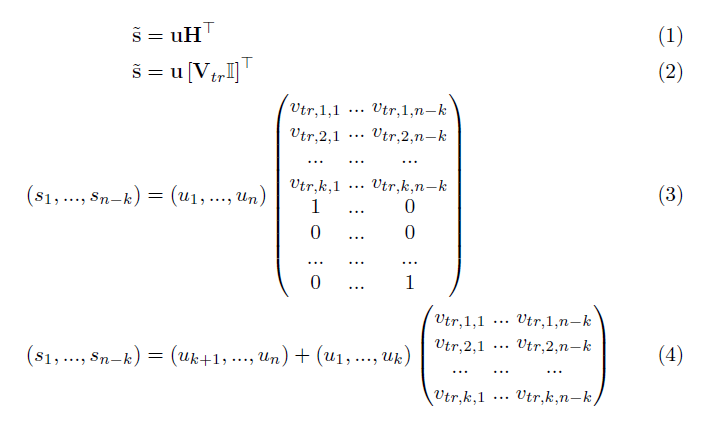

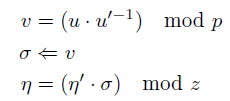

### Simplificación de las filas de matriz identidad

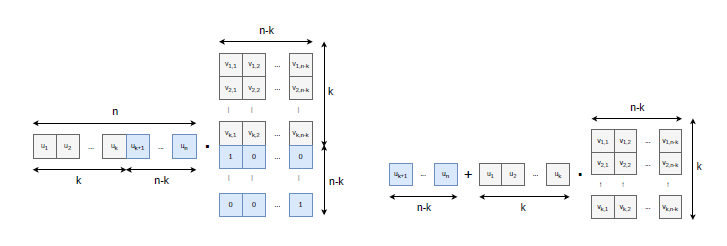

### Montando el ataque

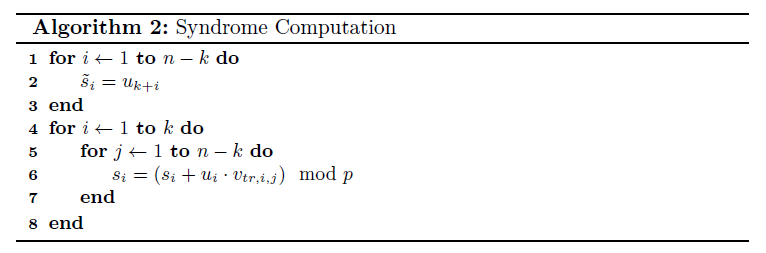

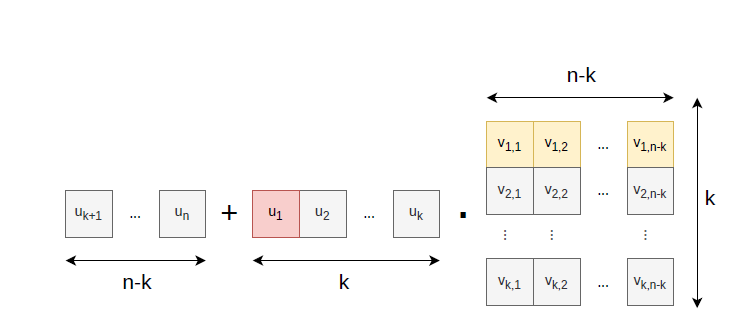

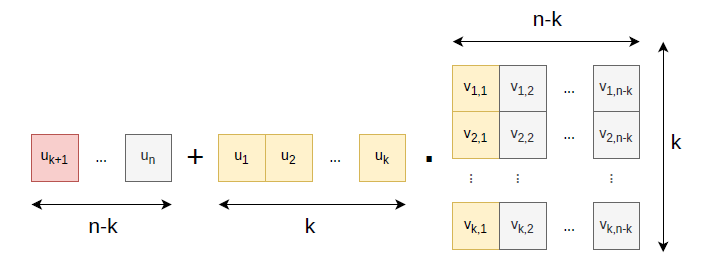